In [9]:
import numpy as np
import pandas as pd
from keras.models import model_from_json
import keras.preprocessing.image as pre
import keras.backend as K
from pyntcloud import PyntCloud
import matplotlib.pyplot as plt
import json
from inference.custom_modules import *
from inference.project import *

In [10]:
# Load model architecture and weights
objs = {'ProjectionLayer': ProjectionLayer, 
        'ReflectionPadding2D': ReflectionPadding2D,
        'InverseDepthNormalization': InverseDepthNormalization,
        'AugmentationLayer': AugmentationLayer}
with open('../../code/trained_models/monovideo.json', 'r') as read_file:
    model_architecture_json = json.load(read_file)
    test_model = model_from_json(model_architecture_json,
                                      custom_objects=objs)
test_model.load_weights('../../code/trained_models/monovideo_weights_epoch_20.h5')
img_shape = test_model.inputs[0].shape[1:]

Instructions for updating:
Colocations handled automatically by placer.


W0521 15:45:08.144357 139674069768000 deprecation.py:323] From /home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use the `axis` argument instead


W0521 15:45:13.916308 139674069768000 deprecation.py:506] From /home/alex/Projects/food_volume_estimation/tests/point_cloud/inference/project.py:205: calling squeeze (from tensorflow.python.ops.array_ops) with squeeze_dims is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Use tf.cast instead.


W0521 15:45:14.032770 139674069768000 deprecation.py:323] From /home/alex/Projects/food_volume_estimation/tests/point_cloud/inference/project.py:243: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [11]:
# Inputs-predictions
input_img = pre.img_to_array(pre.load_img('inference/input_frame.jpg')) / 255
test_data = [np.reshape(input_img, (1,)+input_img.shape),
             np.reshape(input_img, (1,)+input_img.shape),
             np.reshape(input_img, (1,)+input_img.shape)]
disp_map = test_model.predict(test_data)[11][0,:,:,0]
min_depth, max_depth = (0.01, 10)
depth = 1 / (1/max_depth + (1/min_depth - 1/max_depth) * disp_map)

In [12]:
# Intrinsics (EPIC dataset)
x_scaling = int(img_shape[1]) / 1920
y_scaling = int(img_shape[0]) / 1080
intrinsics = np.array([[604.54*x_scaling, 0, 960*x_scaling],
                       [0, 181.73*y_scaling, 540*y_scaling],
                       [0,0 ,1]], dtype=np.float32)
intrinsics_inv = np.linalg.inv(intrinsics)

In [13]:
# Get point cloud
depth_tensor = K.variable(np.expand_dims(depth, 0))
intrinsics_inv_tensor = K.variable(np.expand_dims(intrinsics_inv, 0))
point_cloud = K.eval(get_cloud(depth_tensor, intrinsics_inv_tensor))

In [14]:
# Create point cloud df
point_cloud = np.reshape(point_cloud, point_cloud.shape[1:]) # Ignore batch size
point_cloud[:,:,0] *= -1 # Invert x axis
point_cloud[:,:,2] *= -1 # Invert z axis
point_cloud = np.reshape(point_cloud,
                         (point_cloud.shape[0]*point_cloud.shape[1], 3))
point_cloud_df = pd.DataFrame(point_cloud, columns=['x','y','z'])

<IPython.core.display.Javascript object>


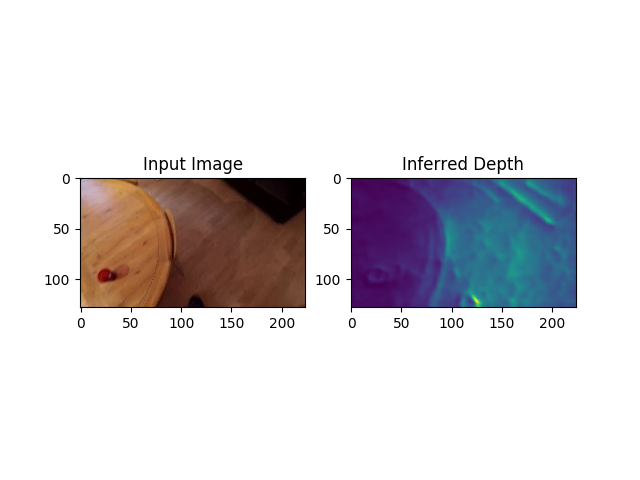

In [15]:
# Plot input and depth images
%matplotlib notebook
plt.subplot(121)
plt.title('Input Image')
plt.imshow(input_img)
plt.subplot(122)
plt.title('Inferred Depth')
plt.imshow(depth)
plt.show()

In [16]:
# Plot point cloud
pc = PyntCloud(point_cloud_df)
pc.plot(initial_point_size=0.001, use_as_color='z')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.07481837272644043, 2.145587610080838, -0.…